# A test for the risk-budgeting model

## Data/Stock choosing:
1. 2010-2022年中一直在上证300中的股票-52只
2. Monthly period from 2010 - 2022. 


In [2]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import test_result

In [3]:
data = pd.read_csv('./data/Monthly_Return_Rates.csv',index_col=0, parse_dates=True,infer_datetime_format = True)
data = data.fillna(0)
rf_df = pd.read_csv('./data/monthly_rf_rate.csv',index_col=0, parse_dates=True,infer_datetime_format = True)
rf_df = rf_df.fillna(0)
index_df = pd.read_csv('./data/000300.csv',index_col=1, parse_dates=True,infer_datetime_format = True)
data['rf'] = rf_df['Nrrmtdt'].values
data['index'] = index_df['Idxrtn']
# 3. Construct risk budgeting portfolio
# portfolio dates
p_dates = data.index[data.index.year>=2017]
# initialise portfolio weights matrix
w = pd.DataFrame(index=p_dates, columns=data.columns)
# initialise portfolio return matrix
p_rets = pd.DataFrame(index=p_dates, columns=['return'])

# Construct Portfolio

* Consider the optimization problem: 

\begin{aligned}
\min_{w} & \quad \sum_{i=1}^N RC_i(w)\\
\textrm{s.t.} & \quad  \boldsymbol{1}^Tw = 1\\
                   & \quad w  \geq \boldsymbol{0}\\
\end{aligned}


* Following the logic from sta4020 asg7. Starting from the end of 2015, at the end of every month, use the historical asset returns (from 2011/1 to the end of that month).

想要有个整体函数可以选择我要的object func和constraint; 

cons_sum_weight()中的tw,cons_large_risk_constraint中的最大risk限制和small_risk_constraint中的最小risk限制也能直接调

In [153]:
"""
This file constructs a strategic ERP portfolio and compare with an equal weighted portfolio.
x: portfolio weights
p_cov: covariance matrix
"""

# risk budgeting approach optimisation object function
# minimize variance
def obj_fun(x, p_cov):
	return np.sum((x*np.dot(p_cov, x)/np.dot(x.transpose(), np.dot(p_cov, x)))**2)

# maximize mean
def obj_fun2(x,p_mean):
	return -np.sum(x*p_mean)

# maximize  mean-variance
def obj_fun3(x,p_mean,p_cov):
	return -np.sum(x*p_mean)+np.sum((x*np.dot(p_cov, x)/np.dot(x.transpose(), np.dot(p_cov, x)))**2)

# maximize sharp ratio
def obj_fun4(x,p_mean,p_cov):
	return -np.sum(x*p_mean)/(np.sum((x*np.dot(p_cov, x)/np.dot(x.transpose(), np.dot(p_cov, x))))**2)

# constraint on sum of weights equal to one
def cons_sum_weight(x,tw):
	return -np.sum(x)+tw

# constraint on weight larger than zero
def cons_long_only_weight(x):
	return x

# constraint about the marignal risk w.r.t. each stocks(upper bound)
def cons_large_risk_constraint(x,p_cov):
	return -x*np.dot(p_cov, x)/np.dot(x.transpose(), np.dot(p_cov, x))+0.05

# constraint about the marignal risk w.r.t. each stocks(lower bound)
def cons_small_risk_constraint(x,p_cov):
	return x*np.dot(p_cov, x)/np.dot(x.transpose(), np.dot(p_cov, x))-0.01

# calculate risk budgeting portfolio weight given risk budget
def rb_p_weights(asset_rets, constrain="1"):
	"""_summary_

	Args:
		asset_rets (_type_): _description_
		constrain (str): In the format of "#+#+#". E.g., "1+3" specifies the first and third type of constraints.

	Returns:
		_type_: _description_
	"""
	# number of ARP series
	num_arp = asset_rets.shape[1]
	# covariance matrix of asset returns
	p_cov = asset_rets.cov()
	# mean of asset returns
	p_mean = asset_rets.mean()
	# initial weights
	w0 = 1.0 * np.ones((num_arp, 1)) / num_arp
	# constraints
	cons1 = {'type': 'eq', 'fun': cons_sum_weight,'args':[1]}
	cons2 = {'type': 'ineq', 'fun': cons_long_only_weight}
	cons3 = {'type':'ineq','fun':cons_large_risk_constraint,'args':[p_cov]}
	cons4 = {'type':'ineq','fun':cons_small_risk_constraint,'args':[p_cov]}
	cons = [cons1, cons2, cons3, cons4]

	cons_strlist = constrain.split(sep='+')
	cons_list = []
	for strnum in cons_strlist:
		cons_list.append(cons[int(strnum)-1])
	# Portfolio optimisation 
	return minimize(obj_fun3, w0, args=(p_mean,p_cov), constraints=cons_list)

# contruct portfolio
def portfolio_construction(momentum_period,rank,p_dates,data,cons):
	for t in p_dates:
		tmp_portfolio = data[data.index <= t]
		tmp_portfolio_t = tmp_portfolio.T
		tmp_portfolio_t['meanofyear'] = tmp_portfolio_t.iloc[:,momentum_period:-1].mean(axis = 1)
		tmp_portfolio_t['rank1'] = tmp_portfolio_t['meanofyear'].rank(ascending = True)#note here is the ascending order
		rank_t = max(rank,tmp_portfolio_t.loc['rf','rank1']+1)
		tmp_portfolio_t = tmp_portfolio_t[tmp_portfolio_t['rank1']>=rank_t].iloc[:,:-2]#here is to drop the coloumns of rf and index
		month_return = tmp_portfolio_t[t]
		tmp_portfolio = (tmp_portfolio_t.T).iloc[:-1,:]#here is to drop the columns of current return
		p_rets.loc[t] = np.sum((rb_p_weights(tmp_portfolio, cons).x) * month_return)
	return test_result.calculate_result(p_rets)
	

In [156]:
portfolio_construction(-4,25,p_dates,data,"1+2")

,accu_return,annual_return,annual_vol,sharpe_ratio,max_dd,winning_rate,karmar
0,0.948924,0.119385,1.283508,0.085223,-0.196938,0.56338,4.818385


## ways without momentum factor

In [ ]:
# contruct portfolio
for t in p_dates:

	# re-balance the portfolio each month
	tmp_portfolio = data[data.index < t]
	tmp_portfolio = tmp_portfolio.iloc[10:,:]
	#w.loc[t] = (rb_p_weights(tmp_portfolio, "1+2").x)
	# calculate risk budgeting portfolio returns
	p_rets.loc[t] = np.sum((rb_p_weights(tmp_portfolio, "1+2").x) * data.loc[t])

# 回测

In [ ]:
for i in range(20):#i is the 52-i stock we decide to keep according to momentum
    for j in range(-6,-2):#j is the momentum period we consider
        print(portfolio_construction(j,i,p_dates,data))

以上回测的结果是动量period3个月效果比较显著,在无论哪个rank的情况下 （这里之后可以画图）

In [53]:
sp = []
ar =[]
for i in range(10,35):
    df = portfolio_construction(-4,i,p_dates,data,"1+2+3")
    sp.append( df['sharpe_ratio'].values)
    ar.append(df['accu_return'].values)


In [55]:
sp = np.array(sp)
ar = np.array(ar)
sp[sp.argmax()],ar[ar.argmax()],sp.argmax(),ar.argmax()

(array([0.09533694]), array([1.0841749]), 24, 18)

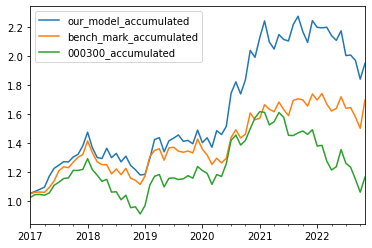

In [117]:
# 4. Construct equal weighted portfolio
ew_rets = pd.DataFrame(np.sum(1.0*data[data.index>=p_dates[0]]/data.shape[1], axis=1), columns=['return'])
# 5. Plot the portfolio cumulative returns
p_cumrets = ((p_rets['return'] + 1).cumprod())
ew_cumrets = (ew_rets['return'] + 1).cumprod()
index_df1 = index_df[index_df.index.year>=2017]
index_cumrets = (index_df1['Idxrtn'] + 1).cumprod()
pd.concat([p_cumrets,ew_cumrets,index_cumrets], axis=1).plot()
plt.legend(['our_model_accumulated','bench_mark_accumulated','000300_accumulated'])
plt.show()

* maximize the sharp ratio and the formula derivation: this repository may helps

https://github.com/PaiViji/PythonFinance--RiskBudgeted-Portfolio-Construction.git

* we can also use this repository to check the quality of our work:

https://github.com/jcrichard/pyrb.git